# Feature Extraction

## Cropping and Resizing (similar to Assignment 1)

### Imports

In [226]:
import os
import xml.etree.ElementTree as ET
from skimage import io
from skimage.transform import resize
import glob
from pathlib import Path
import numpy as np

### Get Bounding Boxes

In [227]:
def get_bounding_boxes(annot):
    tree = ET.parse(annot)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

### Crop and Resize

In [228]:
def process_image(image_file, bounding_boxes, output_folder):
    image = io.imread(image_file)
    #Assignment 4 asked for 224 × 224 pixel image
    image_size = (224, 224)

    cropped_image_list = []

    for i, bbox in enumerate(bounding_boxes):
        xmin, ymin, xmax, ymax = bbox
        cropped_image = image[ymin:ymax, xmin:xmax]
        resized_image = resize(cropped_image, image_size, anti_aliasing=True)
        
        resized_image_uint8 = (resized_image * 255).astype(np.uint8)

        # Ensure output directory exists
        Path(output_folder).mkdir(parents=True, exist_ok=True)

        output_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_file))[0]}_bbox_{i}.jpg")
        io.imsave(output_path, resized_image_uint8)
        cropped_image_list.append(output_path)

    return cropped_image_list

### Folders Settings

In [229]:
image_folder = './data/Images/*/*'
annotation_folder = './data/Annotations/*/*'
output_folder = './data/Cropped Images'

image_files = glob.glob(image_folder)
annotation_files = glob.glob(annotation_folder)

### Run 

In [230]:
annotations = {os.path.splitext(os.path.basename(f))[0]: f for f in annotation_files}

for image_file in image_files:
    image_code_name = os.path.splitext(os.path.basename(image_file))[0]
    annotation_file = annotations.get(image_code_name)
    
    if annotation_file:
        bbox = get_bounding_boxes(annotation_file)
        breed_folder = os.path.basename(os.path.dirname(image_file))
        breed_output_folder = os.path.join(output_folder, breed_folder)     
        cropped_images = process_image(image_file, bbox, breed_output_folder)


## Normalizing ([https://kozodoi.me/blog/20210527/extracting-features ] was used as a reference)

### Imports

In [231]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image

### Dataset

In [232]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(image=np.array(img))["image"]

        return img

### Image paths

In [233]:
image_folder = f'{output_folder}/*/*'
image_files = glob.glob(image_folder)


### Transforming 

In [234]:
transform = A.Compose([
        A.Resize(height=224, width=224), #no need but just in case
        A.Normalize(),  
        ToTensorV2()    
])

dataset = ImageDataset(
        image_paths=image_files, 
        transform=transform
)

data_loader = DataLoader(dataset, batch_size=32, num_workers=0)


## Extracting Features ([https://kozodoi.me/blog/20210527/extracting-features ] was used as a reference)

### Imports

In [235]:
import torch
import torch.nn as nn
import timm

### Building Model

In [236]:
#As a mac user, I cannot use 'cuda'
device = torch.device("mps")

model = timm.create_model(model_name="resnet18", pretrained=True)
model.fc = nn.Linear(512, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

### Hook function

In [237]:
def get_features_hook(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


### Registering a hook

In [238]:
model.global_pool.register_forward_hook(get_features_hook("feats"))


### Feature Extraction Loop

In [239]:
PREDS = []
FEATS = []

features = {}

for idx, inputs in enumerate(data_loader):
    inputs = inputs.to(device)

    # Forward pass with feature extraction
    preds = model(inputs)

    # Append the predictions to PREDS and the features to FEATS
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features["feats"].cpu().numpy())


### Inspecting Features

In [240]:
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print("- preds shape:", PREDS.shape)
print("- feats shape:", FEATS.shape)

- preds shape: (660, 2)
- feats shape: (660, 512)


# Dimensionality reduction (similar to Assignment 1)

### Imports

In [241]:
from sklearn.decomposition import PCA

### Performing PCA

In [242]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(FEATS)

# Clustering Algorithm

## K-mean clusterings for 𝐾 = 4

### Imports

In [243]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import SpectralClustering

### K-means clustering

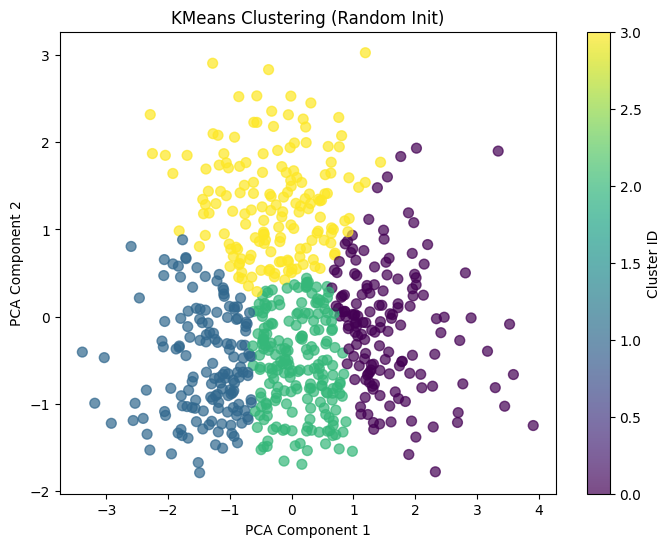

In [244]:
kmeans_random = KMeans(
            n_clusters=4, 
            init='random', 
            random_state=42
)

kmeans_random_labels = kmeans_random.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_random_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("KMeans Clustering (Random Init)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

### KMeans with init=‘k-means++’

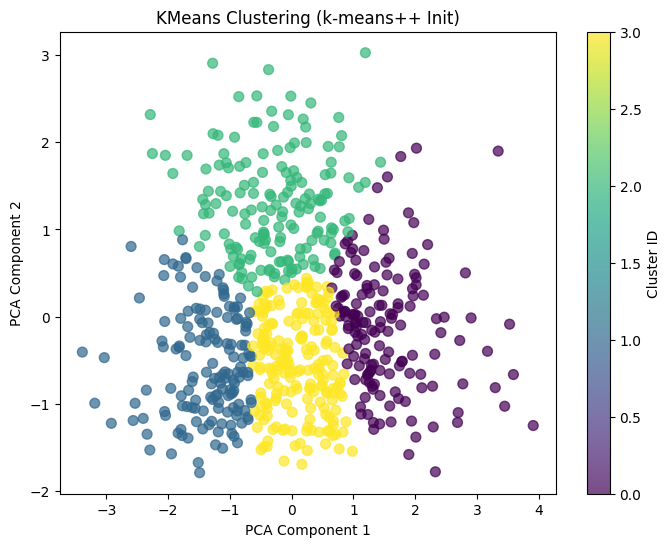

In [245]:
kmeans_plus = KMeans(
            n_clusters=4, 
            init='k-means++', 
            random_state=42
)

kmeans_plus_labels = kmeans_plus.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_plus_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("KMeans Clustering (k-means++ Init)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

### Bisecting K-means

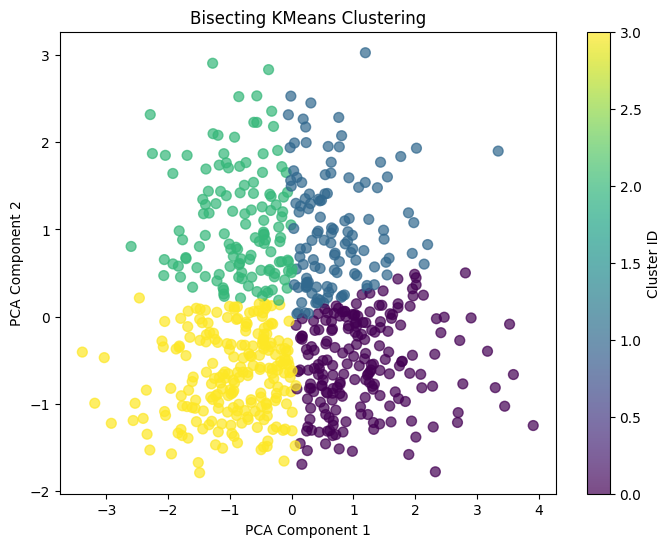

In [246]:
bisecting_kmeans = BisectingKMeans(
            n_clusters=4, 
            init='random', 
            random_state=42
)

bisecting_kmeans_labels = bisecting_kmeans.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=bisecting_kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Bisecting KMeans Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

### Spectral Clustering

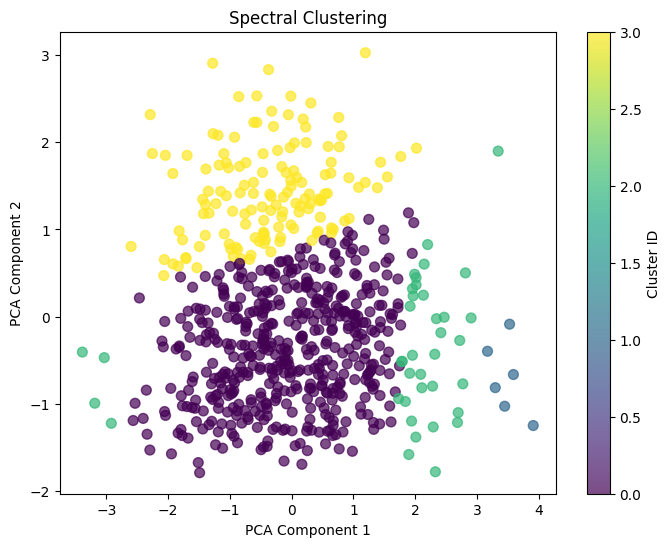

In [247]:
spectral = SpectralClustering(
            n_clusters=4, 
            random_state=42
)

spectral_labels = spectral.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=spectral_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Spectral Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

## DBSCAN

### Imports

In [248]:
from sklearn.cluster import DBSCAN

### DBSCAN clustering

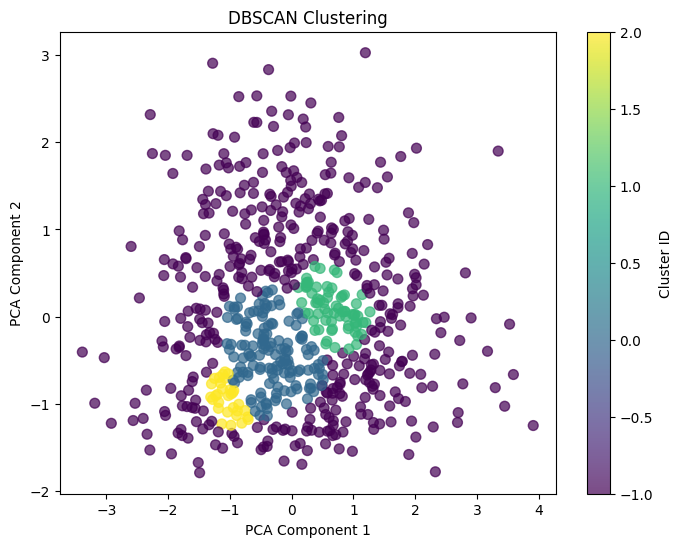

In [249]:
dbscan = DBSCAN(eps=0.4, min_samples=41)  
dbscan_labels = dbscan.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

Using eps=0.4 and min_samples=41, I was able to get 4 visually separable clusters.

## Agglomerative clustering

### Imports

In [250]:
from sklearn.cluster import AgglomerativeClustering

### Single link (MIN)

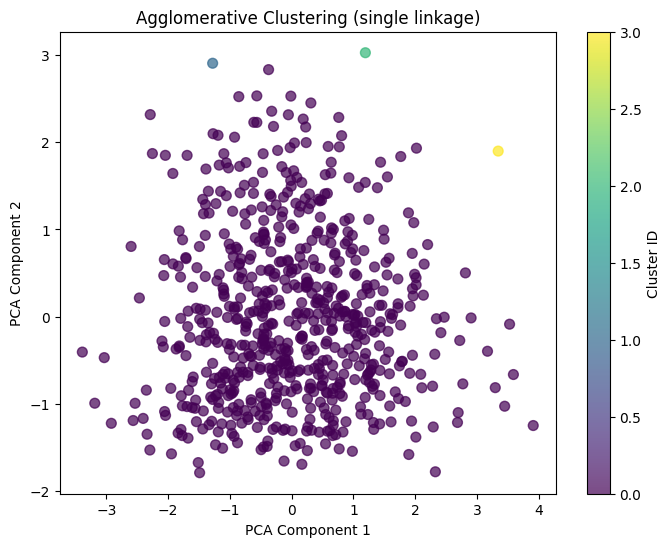

In [251]:
agglom_min = AgglomerativeClustering(n_clusters=4, linkage='single')
agglom_min_labels = agglom_min.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=agglom_min_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Agglomerative Clustering (single linkage)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

### Complete link (MAX)

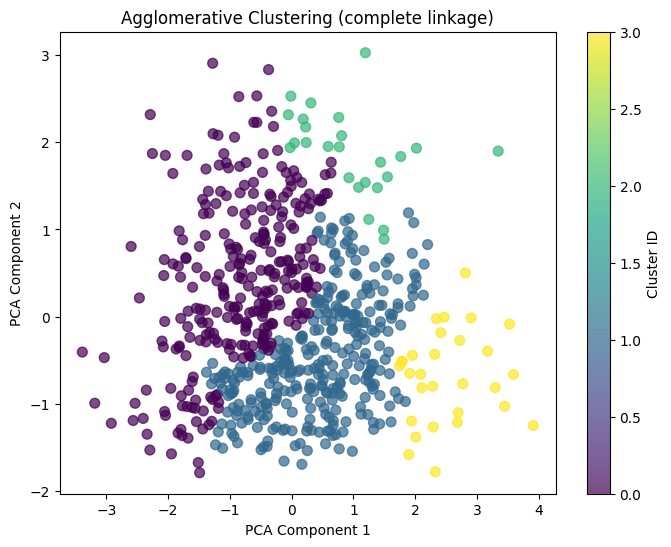

In [252]:
agglom_max = AgglomerativeClustering(n_clusters=4, linkage='complete')
agglom_max_labels = agglom_max.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=agglom_max_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Agglomerative Clustering (complete linkage)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

### Group Average

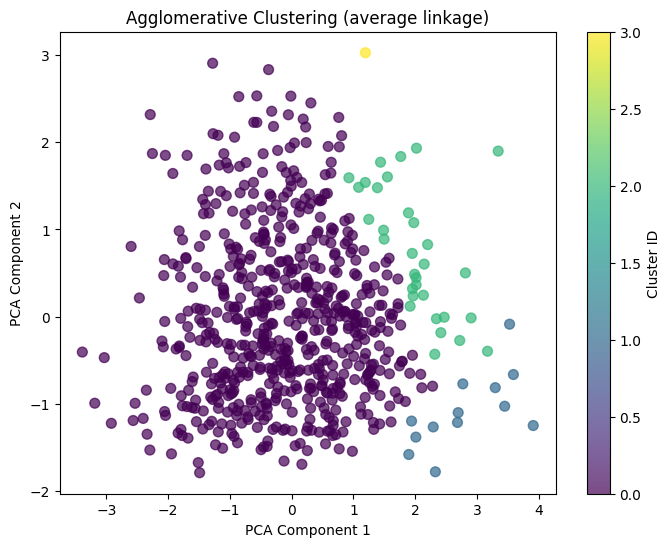

In [253]:
agglom_avg = AgglomerativeClustering(n_clusters=4, linkage='average')
agglom_avg_labels = agglom_avg.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=agglom_avg_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Agglomerative Clustering (average linkage)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

### Ward’s method

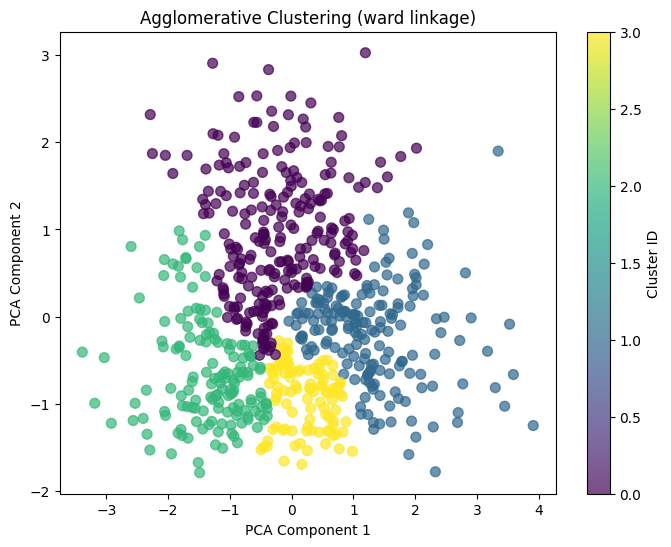

In [254]:
agglom_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglom_ward_labels = agglom_ward.fit_predict(reduced_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=agglom_ward_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Agglomerative Clustering (ward linkage)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

# Clustering Evaluation

## Extracting True Labels

In [255]:
def get_true_labels(image_files):
    labels = []
    for image_file in image_files:
        breed_folder = os.path.basename(os.path.dirname(image_file))  # Extract breed or class from folder
        labels.append(breed_folder)  # Add the class label
    return labels

true_labels = get_true_labels(image_files)

unique_labels = np.unique(true_labels)
label_mapping = {label: i for i, label in enumerate(unique_labels)}
encoded_true_labels = np.array([label_mapping[label] for label in true_labels])


## Perform Clustering Performance Evaluation

### Imports

In [256]:
from sklearn.metrics import fowlkes_mallows_score, silhouette_score


### Fowlkes-Mallows index

In [257]:
kmeans_random_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    kmeans_random_labels
)  

kmeans_plus_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    kmeans_plus_labels
)

kmeans_bisecting_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    bisecting_kmeans_labels
)

spectral_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    spectral_labels
)

dbscan_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    dbscan_labels
)

agglom_min_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    agglom_min_labels
)

agglom_max_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    agglom_max_labels
)

agglom_avg_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    agglom_avg_labels
)

agglom_ward_fmi = fowlkes_mallows_score(
    encoded_true_labels, 
    agglom_ward_labels
)

fmi_scores = {
    "K-means Clustering": kmeans_random_fmi,
    "KMeans with init='k-means++'": kmeans_plus_fmi,
    "Bisecting K-means": kmeans_bisecting_fmi,
    "Spectral Clustering": spectral_fmi,
    "DBSCAN": dbscan_fmi,
    "Single link (MIN)": agglom_min_fmi,
    "Complete link (MAX)": agglom_max_fmi,
    "Group Average": agglom_avg_fmi,
    "Ward’s method": agglom_ward_fmi
}

### Silhouette Coefficient

In [258]:
kmeans_silhouette_random = silhouette_score(
    reduced_features, 
    kmeans_random_labels
)

kmeans_plus_silhouette = silhouette_score(
    reduced_features, 
    kmeans_plus_labels
)

kmeans_bisecting_silhouette = silhouette_score(
    reduced_features, 
    bisecting_kmeans_labels
)

spectral_silhouette = silhouette_score(
    reduced_features, 
    spectral_labels
)

dbscan_silhouette = silhouette_score(
    reduced_features, 
    dbscan_labels
)

agglom_min_silhouette = silhouette_score(
    reduced_features, 
    agglom_min_labels
)

agglom_max_silhouette = silhouette_score(
    reduced_features, 
    agglom_max_labels
)

agglom_avg_silhouette = silhouette_score(
    reduced_features, 
    agglom_avg_labels
)

agglom_ward_silhouette = silhouette_score(
    reduced_features, 
    agglom_ward_labels
)

silhouette_scores = {
    "K-means Clustering": kmeans_silhouette_random,
    "KMeans with init='k-means++'": kmeans_plus_silhouette,
    "Bisecting K-means": kmeans_bisecting_silhouette,
    "Spectral Clustering": spectral_silhouette,
    "DBSCAN": dbscan_silhouette,
    "Single link (MIN)": agglom_min_silhouette,
    "Complete link (MAX)": agglom_max_silhouette,
    "Group Average": agglom_avg_silhouette,
    "Ward’s method": agglom_ward_silhouette
}

## Ranking the Methods From the Best to the Worst

### Ranking Fowlkes-Mallows

In [259]:
sorted_fmi = sorted(fmi_scores.items(), key=lambda x: x[1], reverse=True)

print("Fowlkes-Mallows Index Ranking:")
for method, score in sorted_fmi:
    print(f"{method}: {score:.4f}")

Fowlkes-Mallows Index Ranking:
Single link (MIN): 0.4973
Group Average: 0.4652
Spectral Clustering: 0.3794
Complete link (MAX): 0.3425
DBSCAN: 0.3419
Bisecting K-means: 0.2680
Ward’s method: 0.2679
K-means Clustering: 0.2564
KMeans with init='k-means++': 0.2564


### Ranking Silhouette Coefficient

In [260]:
sorted_silhouette = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

print("\nSilhouette Score Ranking:")
for method, score in sorted_silhouette:
    print(f"{method}: {score:.4f}")


Silhouette Score Ranking:
K-means Clustering: 0.3371
KMeans with init='k-means++': 0.3371
Bisecting K-means: 0.3347
Single link (MIN): 0.3064
Ward’s method: 0.2739
Spectral Clustering: 0.2674
Group Average: 0.2470
Complete link (MAX): 0.1966
DBSCAN: -0.1244
